In [2]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sb
from warnings import *
filterwarnings("ignore")
import  tensorflow   as  tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [33]:
train,test,validation = tfds.load("dtd",split=['train[:80%]','train[80%:90%]','validation[90%:]'],batch_size=-1)
print("Done!")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/dtd/3.0.1.incompleteV17THS/dtd-train.tfrecord*...:   0%|          | 0/1880…

Generating test examples...:   0%|          | 0/1880 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/dtd/3.0.1.incompleteV17THS/dtd-test.tfrecord*...:   0%|          | 0/1880 …

Generating validation examples...:   0%|          | 0/1880 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/dtd/3.0.1.incompleteV17THS/dtd-validation.tfrecord*...:   0%|          | 0…

Dataset dtd downloaded and prepared to /root/tensorflow_datasets/dtd/3.0.1. Subsequent calls will reuse this data.
Done!


In [ ]:
train['label']

<tf.Tensor: shape=(1504,), dtype=int64, numpy=array([13,  2, 12, ..., 27, 11, 32])>

In [ ]:
print(f"Shape : {train['image'].shape} images ;\n\n Train : {len(train['image'])} images  ;\n\n Test : {len(test['image'])} images ;\n\n validation : {len(validation['image'])} images ; ")

Shape : (1504, 701, 800, 3) images ;

 Train : 1504 images  ;

 Test : 188 images ;

 validation : 188 images ; 


In [34]:
datas = tfds.builder('dtd')
info = datas.info
print(info)

tfds.core.DatasetInfo(
    name='dtd',
    full_name='dtd/3.0.1',
    description="""
    The Describable Textures Dataset (DTD) is an evolving collection of textural
    images in the wild, annotated with a series of human-centric attributes,
    inspired by the perceptual properties of textures. This data is made available
    to the computer vision community for research purposes.
    
    The "label" of each example is its "key attribute" (see the official website).
    The official release of the dataset defines a 10-fold cross-validation
    partition. Our TRAIN/TEST/VALIDATION splits are those of the first fold.
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/dtd/index.html',
    data_path='/root/tensorflow_datasets/dtd/3.0.1',
    file_format=tfrecord,
    download_size=596.28 MiB,
    dataset_size=603.00 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': C

In [35]:
num_classes = info.features['label'].num_classes
labels = []
for i in range(num_classes):
    labels.append(info.features['label'].int2str(i))
len(labels)

47

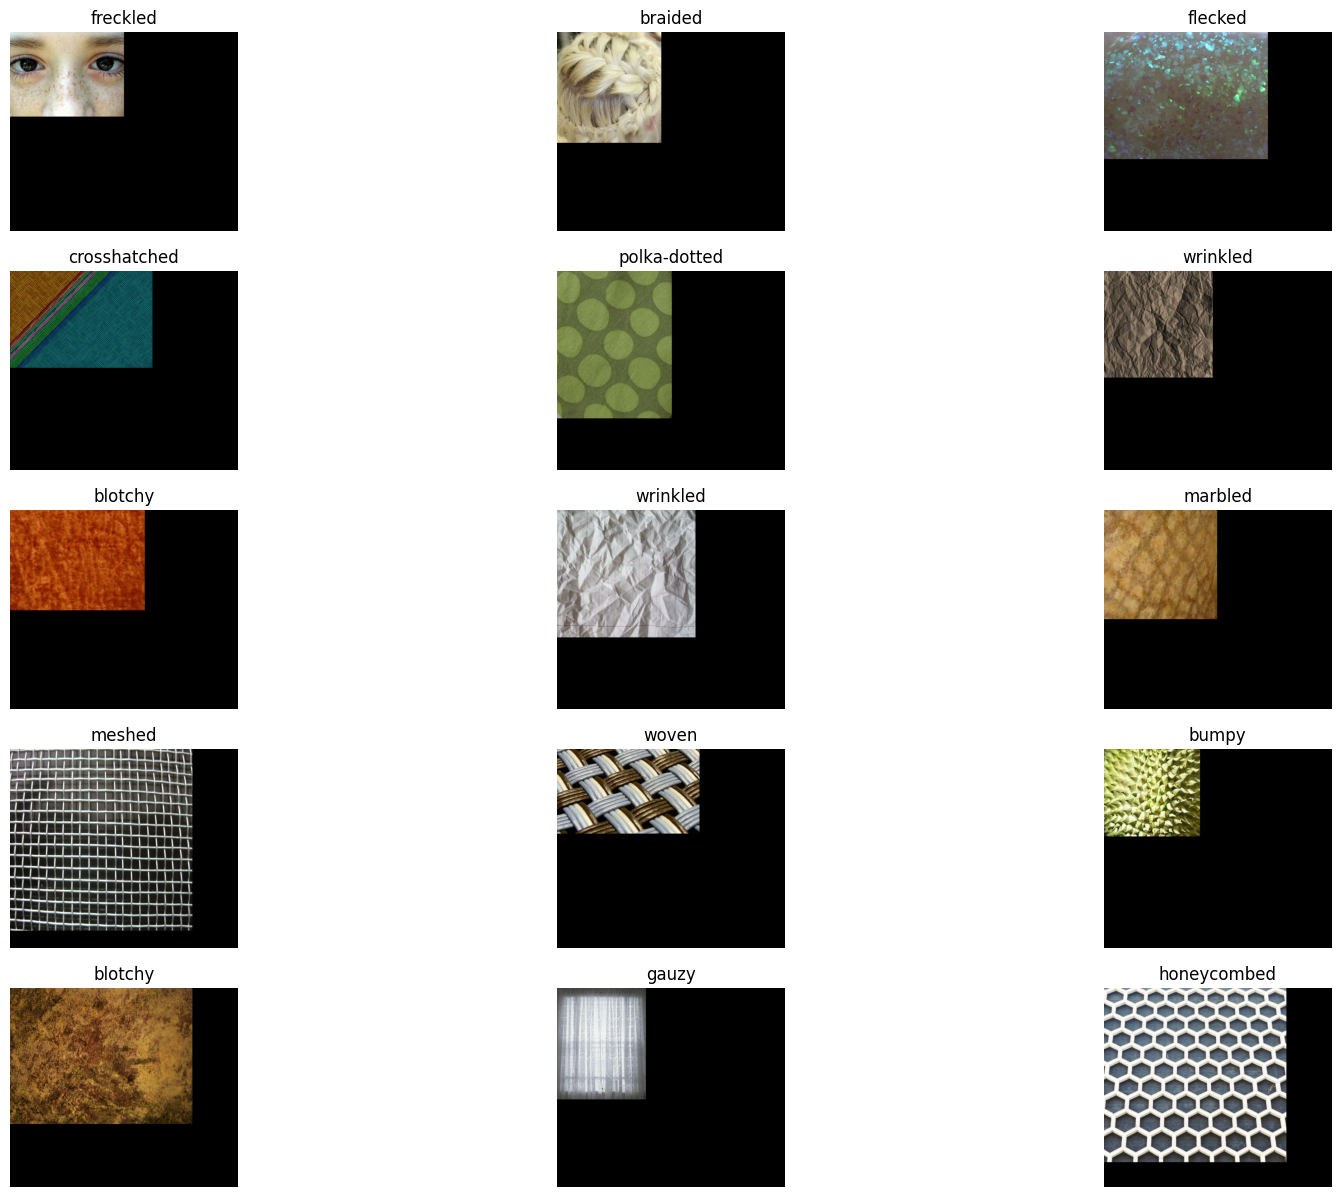

In [ ]:
plt.figure(figsize=(20,15))
random_state = 36
dime = [96,96,3]
for i in range(15):
    ax = plt.subplot(5,3,i+1)
    image = train['image'][i]
    plt.imshow(image)
    plt.title(labels[train['label'][i]])
    plt.axis("off")
plt.show()

In [36]:
train_data,train_label = tfds.as_numpy(train['image']),tfds.as_numpy(train['label'])
test_data,test_label = tfds.as_numpy(test['image']),tfds.as_numpy(test['label'])
validation_data,validation_label = tfds.as_numpy(validation['image']),tfds.as_numpy(validation['label'])

In [37]:
def resizing(images):
    im_data = []
    for image in images:
      img = cv2.resize(image,(224,224),interpolation=cv2.INTER_AREA)
      im_data.append(img)
    return im_data
def preprocess(imgs,labs):
    imgs = np.array(imgs)
    imgs = imgs/255.0
    imgs = imgs.astype('float32')
    labs = np.array(labs)
    label = labs.astype("uint32")
    return imgs,label

In [38]:
x_train = resizing(train_data)
x_test = resizing(test_data)
x_train,y_train = preprocess(x_train,train_label)
x_test,y_test = preprocess(x_test,test_label)

In [39]:
x_val = resizing(validation_data)
x_valid,y_valid = preprocess(x_val,validation_label)

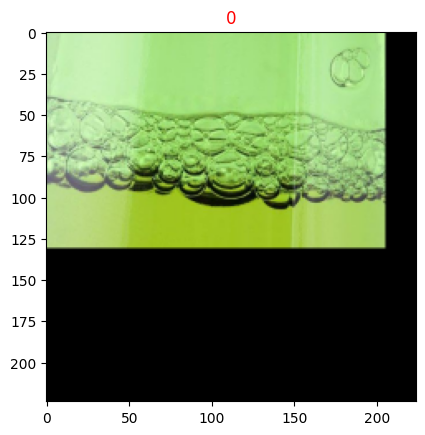

In [ ]:
plt.imshow(x_test[1])
plt.title(np.argmax(y_test[1]),color='red')
plt.show()

In [40]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,y_valid)).batch(32)

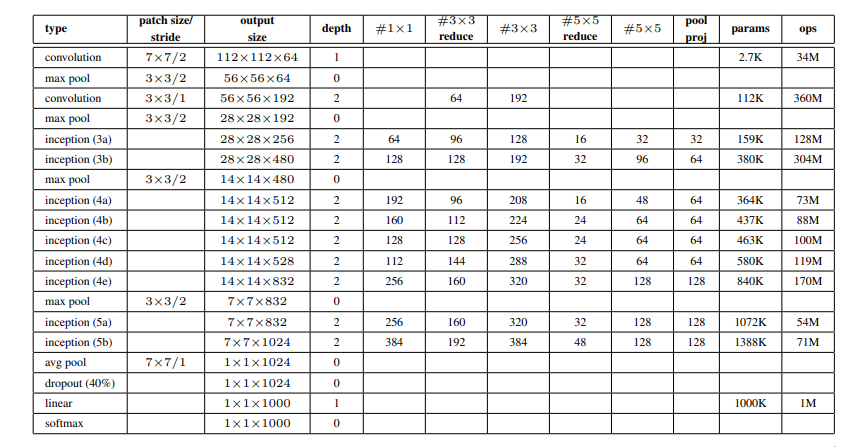

In [10]:
def inception_layer(x,filters,stage,block):
    filter_1x1a,filter_1x1b,filter_1x1c,filter_1x1d,filter_3x3,filter_5x5 = filters
    b_name = 'batchstage_'+str(stage)+block
    c_name = 'convstage_'+str(stage)+block
                           # layer_1
    x_1x1a = tf.keras.layers.BatchNormalization(axis=3,name=b_name+'A')(x)
    x_1x1a = tf.keras.layers.Activation('relu')(x_1x1a)
    x_1 = tf.keras.layers.Conv2D(filter_1x1a,kernel_size=(1,1),padding='same',kernel_regularizer='l1',name=c_name+'1x1a')(x_1x1a)
                           # layer_2
    x_1x1b = tf.keras.layers.BatchNormalization(axis=3,name=b_name+'B1')(x)
    x_1x1b = tf.keras.layers.Activation('relu')(x_1x1b)
    x_1x1b = tf.keras.layers.Conv2D(filter_1x1b, kernel_size=(1, 1), padding='same',kernel_regularizer='l1',name=c_name+'1x1b')(x_1x1b)
    x_3x3 = tf.keras.layers.BatchNormalization(axis=3,name=b_name+'B2')(x_1x1b)
    x_3x3= tf.keras.layers.Activation('relu')(x_1x1b)
    x_2 = tf.keras.layers.Conv2D(filter_3x3, kernel_size=(3, 3),padding='same',kernel_regularizer='l1',name=c_name+'3x3')(x_3x3)
                          # layer_3
    x_1x1c = tf.keras.layers.BatchNormalization(axis=3,name=b_name+'C1')(x)
    x_1x1c= tf.keras.layers.Activation('relu')(x_1x1c)
    x_1x1c = tf.keras.layers.Conv2D(filter_1x1c, kernel_size=(1, 1), padding='same',kernel_regularizer='l1',name=c_name+'1x1c')(x_1x1c)
    x_5x5 = tf.keras.layers.BatchNormalization(axis=3,name=b_name+'C2')(x_1x1c)
    x_5x5= tf.keras.layers.Activation('relu')(x_5x5)
    x_3= tf.keras.layers.Conv2D(filter_5x5, kernel_size=(5,5),padding='same',kernel_regularizer='l1',name=c_name+'5x5')(x_5x5)
                          # layer_4
    max_pooling = tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=1,padding='same')(x)
    x_1x1d = tf.keras.layers.BatchNormalization(axis=3,name=b_name+'D')(max_pooling)
    x_1x1d= tf.keras.layers.Activation('relu')(x_1x1d)
    x_4 = tf.keras.layers.Conv2D(filter_1x1c,kernel_size=(1,1),padding='same',kernel_regularizer='l1',name=c_name+'1x1d')(x_1x1d)
                          # concatenate
    concat = tf.keras.layers.Concatenate(axis=-1)([x_1,x_2,x_3,x_4])
    return concat
def classifier_layer(x,num_classes,stage,block):
    class_name = "class_"+str(stage)+block
    x = tf.keras.layers.AveragePooling2D((5,5), strides = 3)(x)
    x = tf.keras.layers.BatchNormalization(axis=3,name='batch'+class_name)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(128, (1,1),name='conv_'+class_name, padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    x = tf.keras.layers.Dense(num_classes)(x)
    x = tf.keras.layers.Activation('softmax')(x)
    return x


In [59]:
class GoogleNet_2(tf.keras.Model):
    def __init__(self, input_shape, classes):
        super(GoogleNet_2, self).__init__(name='inception_1')
        #architecture

        self.classes = classes
        # convolution 7x7/2
        self.input_data = tf.keras.layers.Input(shape=input_shape)
        x = tf.keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=2,kernel_regularizer='l1',name='convstage_1')(self.input_data)
        x = tf.keras.layers.BatchNormalization(axis=3,name='batchstage_1')(x)
        x = tf.keras.layers.Activation('relu')(x)
        #maxpool  3x3/2
        x = tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=2)(x)
        #convolution 3x3/1
        x = tf.keras.layers.Conv2D(filters=192,kernel_size=(3,3),strides=1,kernel_regularizer='l1',padding='same',name='convstage_2')(x)
        x = tf.keras.layers.BatchNormalization(axis=3,name='batchstage_2')(x)
        x = tf.keras.layers.Activation('relu')(x)
        #maxpool  3x3/2
        x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3),strides=2)(x)

        # inception_stage 1
        inception_3a = inception_layer(x,[64,96,16,32, 128, 32],1,"3a_")
        inception_3b = inception_layer(inception_3a,[128,128,32,96,192,64],1,"3b_")
        # maxpool 3x3/2
        maxpool_3 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2)(inception_3b)
        # inception_stage 2
        inception_4a = inception_layer(maxpool_3,[192,96,16,48,208,64],2,'4a_')
        inception_4b = inception_layer(inception_4a,[160,112,24,64,224,64],2,'4b_')
        inception_4c = inception_layer(inception_4b,[128,128,24,64,256,64],2,'4c_')
        inception_4d = inception_layer(inception_4c,[112,144,32,64,288,64],2,'4d_')
        inception_4e = inception_layer(inception_4d,[256,160,32,128,320,128],2,'4e_')
        # classification
        classification_1 = classifier_layer(inception_4a,self.classes,2,'_4a')
        classification_2 = classifier_layer(inception_4d,self.classes,2,'_4d')
        # maxpool 3x3/2
        maxpool_4 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3),strides=2)(inception_4e)
        # inception_layer 3
        inception_5a =inception_layer(maxpool_4,[256,160,32,128,320,128],3,'5a_')
        inception_5b =inception_layer(inception_5a,[384,192,48,128,384,128],3,'5b_')
        # Last_layer
        x = tf.keras.layers.BatchNormalization(axis=3,name='batchstage_6')(inception_5b)
        x = tf.keras.layers.Activation('relu')(x)
        # average pooling
        avrpool = tf.keras.layers.AveragePooling2D((5, 5))(x)
        dropout = tf.keras.layers.Dropout(0.4)(avrpool)
        flatten = tf.keras.layers.Flatten()(dropout)
        # Linear
        linear_layer = tf.keras.layers.Dense(self.classes)(flatten)
        last = tf.keras.layers.Activation('relu')(linear_layer)
        # Building a model
        self.class_1 = tf.keras.Model(inputs=self.input_data, outputs=classification_1)
        self.class_2 = tf.keras.Model(inputs=self.input_data, outputs=classification_2)
        self.inception_model = tf.keras.Model(inputs=self.input_data, outputs=last)
    def call(self,x):
        return self.inception_model(x)

In [60]:
Classes=47
input_size=(224,224,3)
googlenet_model = GoogleNet_2(input_shape=input_size, classes=Classes)

In [61]:
googlenet_model.build((None,224,224,3))

In [62]:
googlenet_model.summary()

Model: "inception_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_15 (Functional)       (None, 47)                2276831   
                                                                 
 model_16 (Functional)       (None, 47)                3774031   
                                                                 
 model_17 (Functional)       (None, 47)                5592255   
                                                                 
Total params: 8179037 (31.20 MB)
Trainable params: 8140253 (31.05 MB)
Non-trainable params: 38784 (151.50 KB)
_________________________________________________________________


In [63]:
#compiler
Optimizer  = tf.keras.optimizers.Adam(learning_rate=0.001)
sparse = tf.keras.losses.SparseCategoricalCrossentropy()

# train objects
loss_obj = tf.keras.metrics.Mean(name='loss')
accuracy_obj = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

# test objects
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [64]:
@tf.function
def training(images, labels):
    with tf.GradientTape() as tape:
        predict = googlenet_model(images, training=True)
        loss_f = sparse(labels, predict)
    gradients = tape.gradient(loss_f, googlenet_model.trainable_variables)
    Optimizer.apply_gradients(zip(gradients, googlenet_model.trainable_variables))
    loss_obj(loss_f)
    accuracy_obj(labels,predict)

In [65]:
@tf.function
def testing(images, labels):
    prediction= googlenet_model(images, training=False)
    valid_loss = sparse(labels, prediction)
    val_loss(valid_loss)
    val_accuracy(labels, prediction)

In [66]:
accuracies = []
val_accuracies=[]
losses=[]
val_losses=[]
epochs = 10
np.argmax([13,9,8])

0

In [67]:
# model fitting
import time
for epoch in range(epochs):
  print(f"Epoch : {epoch+1}/{epochs} ")
  #training
  start_sec = time.time()
  start_ms = time.perf_counter() * 1000
  accuracy_obj.reset_states()
  loss_obj.reset_states()
  val_accuracy.reset_states()
  val_loss.reset_states()
  for  i , j in train_ds:
    training(i,j)
  accuracies.append(accuracy_obj.result())
  losses.append(loss_obj.result())


  #testing
  for  i , j in test_ds:
     testing(i,j)

  val_accuracies.append(val_accuracy.result())
  val_losses.append(val_loss.result())


  end_sec = time.time()
  end_ms = time.perf_counter() * 1000
  sec = end_sec-start_sec
  ms = end_ms-start_ms
  seconds = int(sec)
  mil_sec = int(ms%1000)
  print(f"[=>=>=>=>=>=>=>=>=>=>=>=>] {seconds} s {mil_sec}ms/step - loss : {loss_obj.result()} - accuracy : {accuracy_obj.result()} - val_loss : {val_loss.result()} - val_acc : {val_accuracy.result()}")
print(f"Training finished your final test loss is --- {((val_losses[-1])*100)} % --- and  test_accuracy --- {((val_accuracies[-1])*100)} %  " )

Epoch : 1/10 


[=>=>=>=>=>=>=>=>=>=>=>=>] 242 s 592ms/step - loss : 10.971830368041992 - accuracy : 0.02460106462240219 - val_loss : 15.950202941894531 - val_acc : 0.010638297535479069
Epoch : 2/10 
[=>=>=>=>=>=>=>=>=>=>=>=>] 223 s 604ms/step - loss : 3.9631285667419434 - accuracy : 0.0226063821464777 - val_loss : 3.8501474857330322 - val_acc : 0.021276595070958138
Epoch : 3/10 
[=>=>=>=>=>=>=>=>=>=>=>=>] 222 s 13ms/step - loss : 3.8568220138549805 - accuracy : 0.0226063821464777 - val_loss : 3.8501474857330322 - val_acc : 0.021276595070958138
Epoch : 4/10 
[=>=>=>=>=>=>=>=>=>=>=>=>] 222 s 629ms/step - loss : 3.8501477241516113 - accuracy : 0.0226063821464777 - val_loss : 3.8501474857330322 - val_acc : 0.021276595070958138
Epoch : 5/10 
[=>=>=>=>=>=>=>=>=>=>=>=>] 222 s 588ms/step - loss : 3.8501477241516113 - accuracy : 0.0226063821464777 - val_loss : 3.8501474857330322 - val_acc : 0.021276595070958138
Epoch : 6/10 
[=>=>=>=>=>=>=>=>=>=>=>=>] 221 s 415ms/step - loss : 3.8579611778259277 - accuracy : 

In [68]:
for valid_img, valid_labels in valid_ds:
    testing(valid_img, valid_labels)
print(f"test_loss:  ~{val_loss.result()}\ntest_accuracy: {val_accuracy.result()}")

test_loss:  ~3.8501474857330322
test_accuracy: 0.018617020919919014


In [69]:
 def hist(losses):
    hist_loss =[]
    for i in losses:
      hist_loss.append(i.numpy())
    return hist_loss

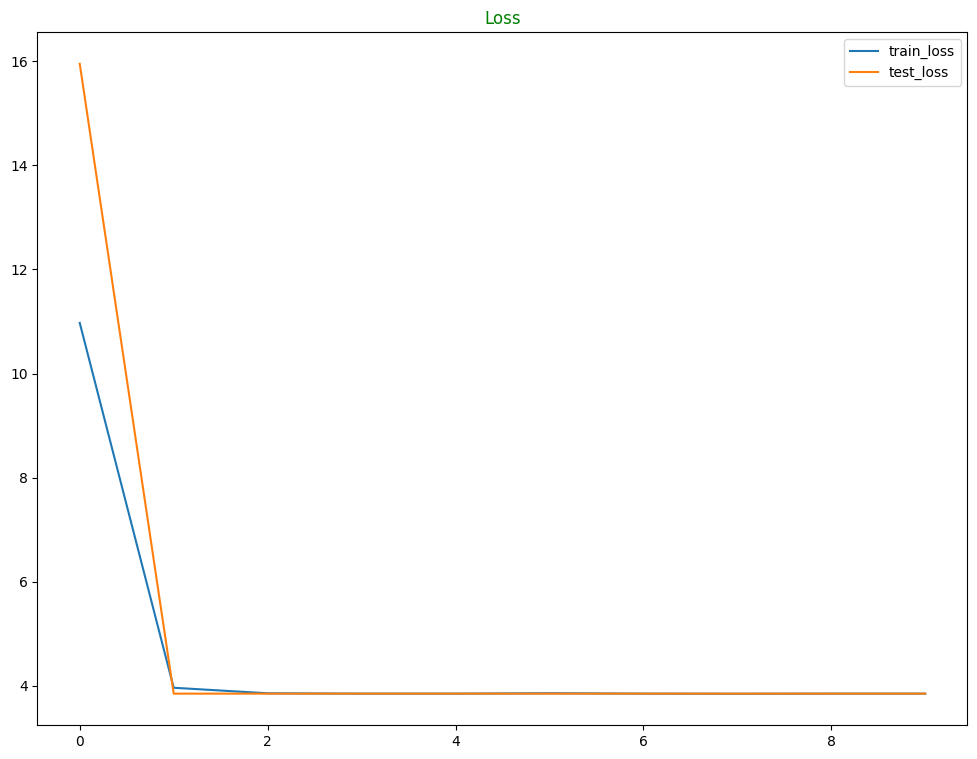

In [70]:
my_losses= hist(losses)
my_test_losses= hist(val_losses)
Epochs = [i for i in range(epochs)]
plt.figure(figsize=(12,9))
plt.title("Loss",color='green')
plt.plot(Epochs,my_losses)
plt.plot(Epochs,my_test_losses)
plt.legend(['train_loss','test_loss'],loc="best")
plt.show()

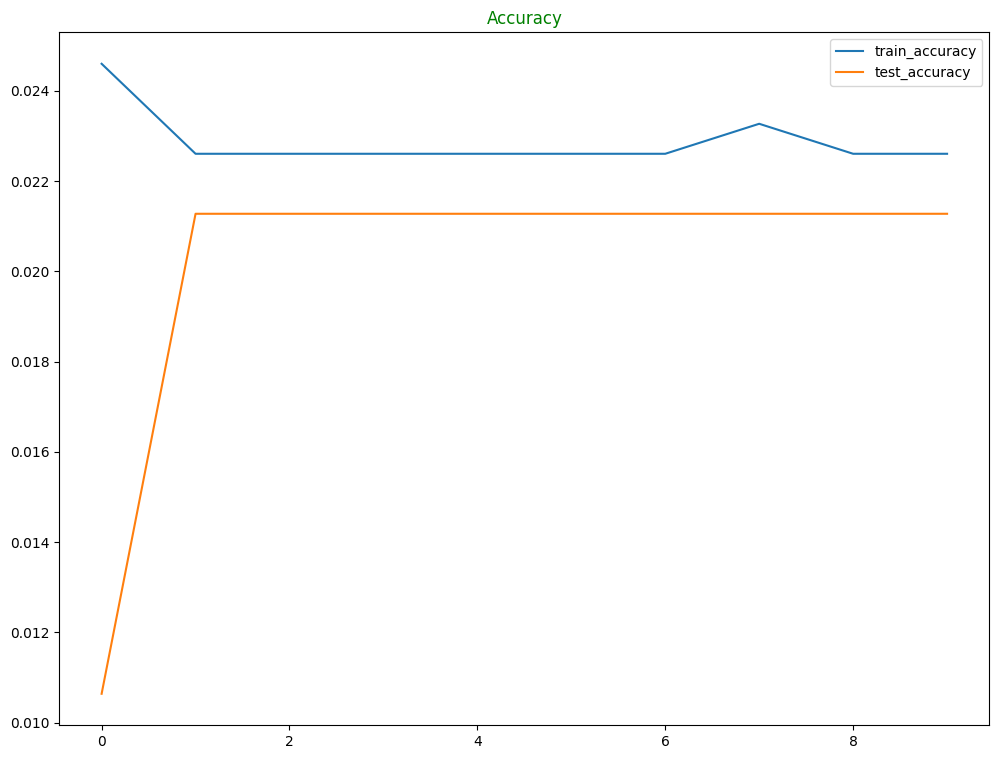

In [71]:
my_accuracies= hist(accuracies)
my_test_accuracies= hist(val_accuracies)
Epochs = [i for i in range(epochs)]
plt.figure(figsize=(12,9))
plt.title("Accuracy",color='green')
plt.plot(Epochs,my_accuracies)
plt.plot(Epochs,my_test_accuracies)
plt.legend(['train_accuracy','test_accuracy'],loc="best")
plt.show()

In [72]:
predictions = googlenet_model.predict(valid_ds)
preds =[]
for i in predictions:
  preds.append(np.argmax(i))

6/6 [==============================] - 7s 1s/step


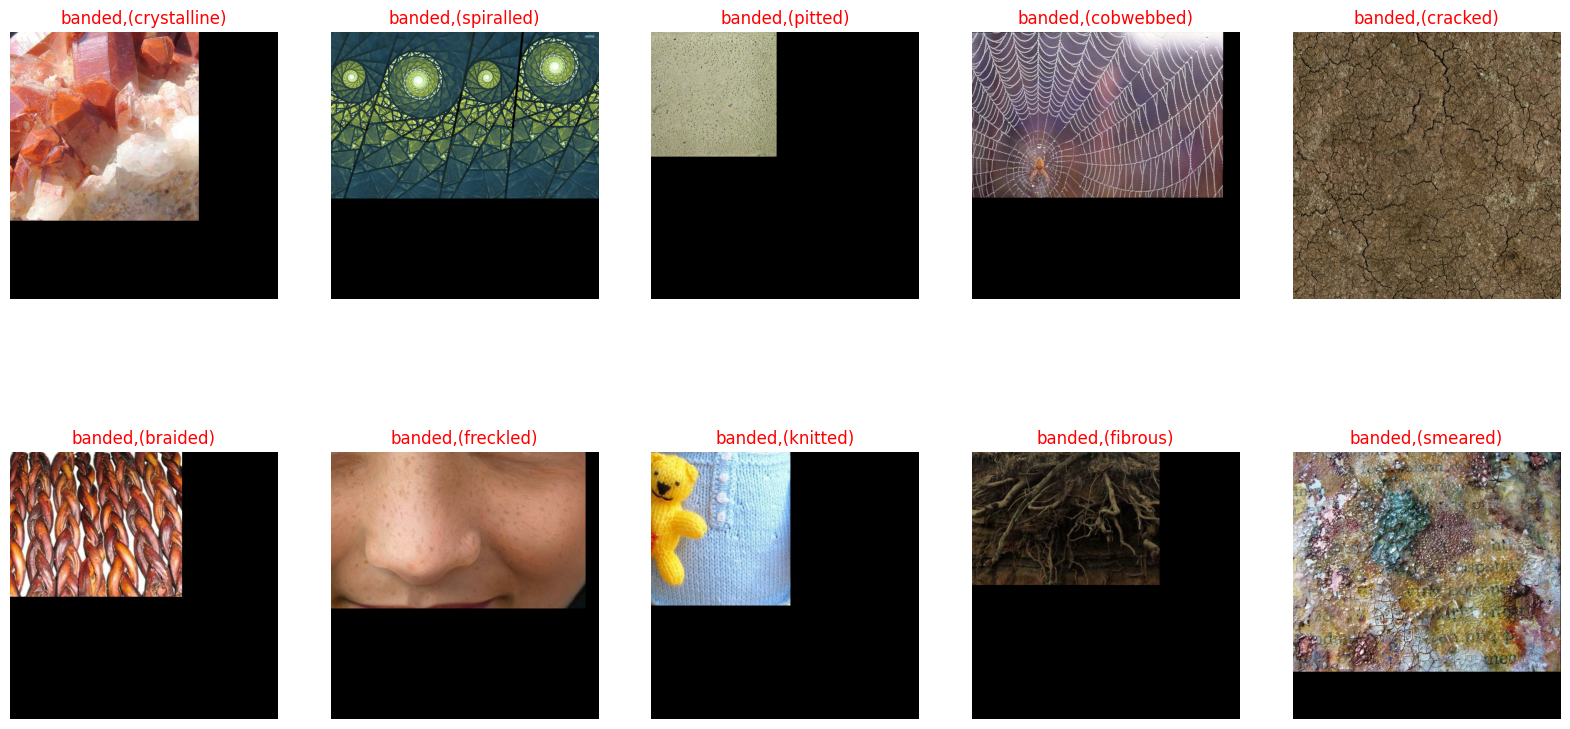

In [73]:
plt.figure(figsize=(20,10))
import random
randomly=[1,11,21,42,85,12,45,8,41,31]
for i in range(len(randomly)):
  ax = plt.subplot(2,5,i+1)
  image = validation['image'][i]
  plt.imshow(image)
  if labels[validation['label'][i]]==labels[preds[i]]:
    plt.title({labels[preds[i]]},color='green')
  else:
    plt.title(f"{labels[preds[i]]},({labels[validation['label'][i]]})",color='red')
  plt.axis("off")
plt.show()

In [74]:
json_model = googlenet_model.to_json()
with open("googlenet_from_scratch.json", "w") as json_file:
    json_file.write(json_model)